In [1]:
from neo.io import Spike2IO
import numpy as np

In [2]:
neo_reader = Spike2IO(filename='../data/mouse_data/N082_1780123_02c_1.smr')

In [3]:
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]

In [4]:
asig = seg.analogsignals[0]

In [5]:
data_block

Block with 1 segments, 2 channel_indexes
annotations: {'system_id': 6}
file_origin: '../data/mouse_data/N082_1780123_02c_1.smr'
# segments (N=1)
0: Segment with 2 analogsignals
   annotations: {'system_id': 6}
   # analogsignals (N=2)
   0: AnalogSignal with 1 channels of length 9973760; units uV; datatype float32 
      name: 'Channel bundle (Spk2-01) '
      annotations: {'channel_names': array(['Spk2-01'], dtype='<U64'),
        'channel_ids': array([16])}
      sampling rate: -40690.104166666664
      time: -0.0 to -245.11512576
   1: AnalogSignal with 1 channels of length 1246870; units uV; datatype float32 
      name: 'Channel bundle (LFPs02) '
      annotations: {'channel_names': array(['LFPs02'], dtype='<U64'),
        'channel_ids': array([17])}
      sampling rate: -5086.263020833333
      time: -0.0 to -245.14461696

In [6]:
voltage = np.asarray(asig)
from kaveh.toolbox import butter_bandpass_filter
Fs = np.double( -1.0*asig.sampling_rate)
# signal_filtered = butter_bandpass_filter(np.squeeze(voltage), 300, 3000, Fs, order=2 )

lfp = np.asarray(seg.analogsignals[1])
Fs_lfp = np.double( -1.0*seg.analogsignals[1].sampling_rate)


In [63]:
np.arange(prange[0],prange[1],1/Fs).size

66732

<IPython.core.display.Javascript object>


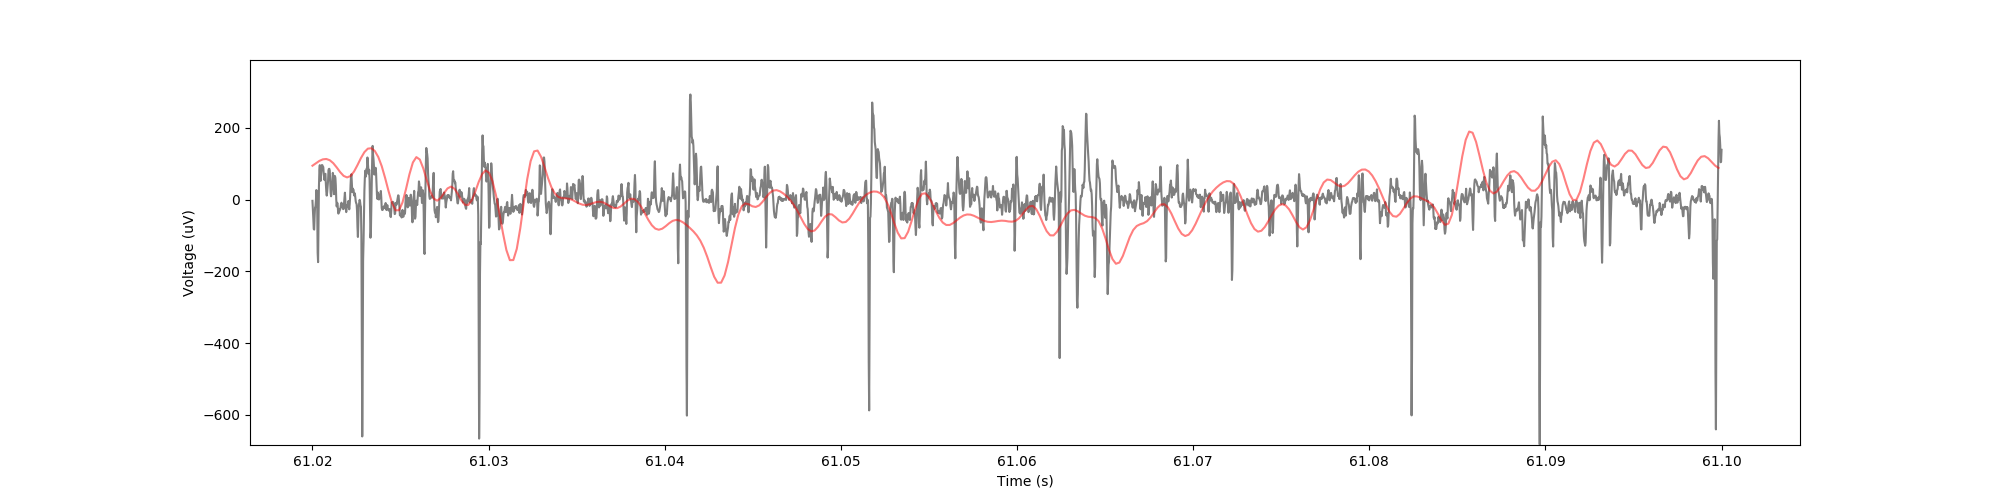

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
prange = [61.02,61.10] #s
idx_voltage = [int(pr*Fs) for pr in prange]
idx_lfp = [int(pr*Fs_lfp) for pr in prange]
t_voltage = np.arange(prange[0],prange[1],1/Fs)
t_lfp = np.arange(prange[0],prange[1],1/Fs_lfp)
plt.plot(t_voltage, voltage[idx_voltage[0]: idx_voltage[0] + t_voltage.size], alpha=0.5, color='k')
plt.plot(t_lfp, lfp[idx_lfp[0]: idx_lfp[0] + t_lfp.size], alpha=0.5, color='r')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
# plt.savefig('../data/plots/For_cssorter_paper/mouse_trace_with_lfp.png')
# plt.savefig('../data/plots/For_cssorter_paper/mouse_trace_with_lfp.svg')
plt.show()

In [68]:
plt.savefig('../data/plots/For_cssorter_paper/mouse_trace_wo_lfp_signature.png')
plt.savefig('../data/plots/For_cssorter_paper/mouse_trace_wo_lfp_signature.svg')

In [7]:
%matplotlib notebook
# %load_ext autoreload
# %autoreload 2

In [8]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(voltage[0 : int(250.0*Fs)] , dt)
css.num_gmm_components = 3
css.cs_num_gmm_components = 5
css.run(use_filtered=False, remove_overlap=False, spike_detection_dir = 'max', align_spikes_to='min')

Pre-process time = 0.09727978706359863
Using minibatch spike detection, batch size = 50s, using filter (derivative) is False
Usinf spikes max for detection. Aligning them to their min. 
Spike detection time = 11.478965520858765
Using all spikes for alignment (no overlap removal)
Align spikes time = 11.547922372817993
Clustering complex spikes...
CS spike detection time = 17.5276882648468
Merging overlapping CS waveforms
CS post process time = 17.53962469100952


In [10]:
css.cs_indices.shape

(3409,)

In [8]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(voltage[0 : int(250.0*Fs)] , dt)
css.cs_num_gmm_components = 5
css.num_gmm_components = 3

css._init_gmm()
css._pre_process()
css._detect_spikes_minibatch(use_filtered=False, select_clust = 'max', align_to='min')

Using minibatch spike detection, batch size = 50s
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative


In [9]:
pre_time = 0.002
post_time = 0.003
pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
aligned_spikes = np.array([css.voltage[i - pre_index : i + post_index] for i in css.spike_indices[1:-2]])

In [1]:
from kaveh.toolbox import chisqr_align

In [20]:
s = chisqr_align(aligned_spikes[2034,:], aligned_spikes[2050,:], [1,aligned_spikes.shape[1]-1])

In [24]:
s

0.1

In [22]:
from scipy.ndimage import shift

In [105]:
og.shape

(100,)

In [50]:
import numpy as np
from scipy import signal
from scipy.ndimage import shift
import matplotlib.pyplot as plt

true signal offset: 4
chi square alignment -3.971029264673738


<IPython.core.display.Javascript object>


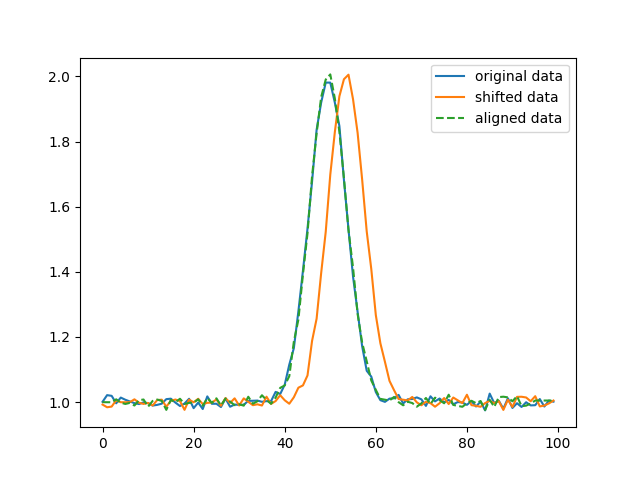

In [103]:
NPTS = 100
SHIFTVAL = 4
NOISE = 1e-2 # can perturb offset retrieval from true
print('true signal offset:',SHIFTVAL)

# generate some noisy data and simulate a shift
og = signal.gaussian(NPTS, std=4) + np.random.normal(1,NOISE,NPTS)
shifted = shift( signal.gaussian(NPTS, std=4) ,SHIFTVAL) + np.random.normal(1,NOISE,NPTS)
s = chisqr_align(og, shifted, [10,90], init=-3.5,bound=2)
print('chi square alignment',s)

# make some diagnostic plots
plt.figure()
plt.plot(og,label='original data')
plt.plot(shifted,label='shifted data')
plt.plot(shift(shifted,s,mode='nearest'),ls='--',label='aligned data') 
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


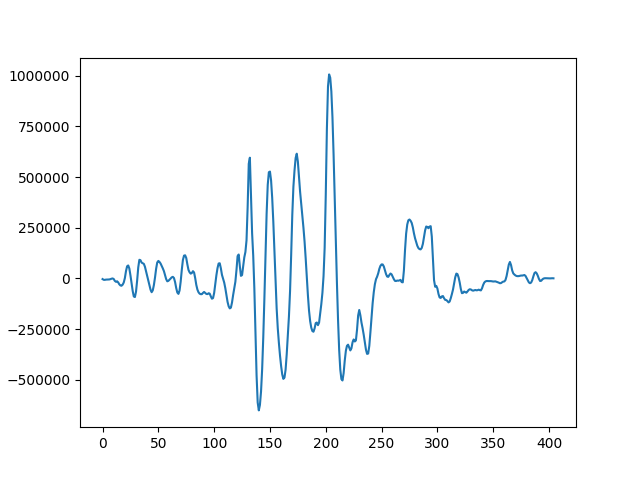

In [59]:
plt.figure()
plt.plot(signal.correlate(sig1,sig2, mode='full'))


In [60]:
np.argsort(signal.correlate(sig1,sig2, mode='full'))[-9]

132

In [194]:
s = (np.argsort(signal.correlate(sig1,sig2, mode='full', method='fft'))[-1]+1) - sig2.size

In [182]:
a = np.array([1,2,4,-1])
np.conj(a)

array([ 1,  2,  4, -1])

In [ ]:
sig1 = aligned_spikes[np.random.randint(aligned_spikes.shape[0]),:]
sig2 = aligned_spikes[np.random.randint(aligned_spikes.shape[0]),:]

-70


<IPython.core.display.Javascript object>


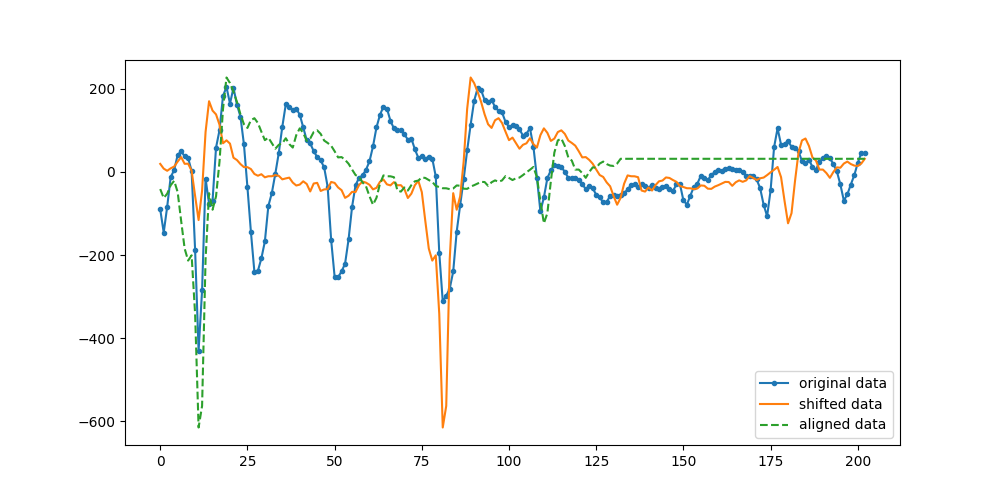

In [58]:
# s = chisqr_align(sig1, sig2, [60,aligned_spikes.shape[1]-60],init=1,bound=10)
s = (np.argsort(signal.correlate(sig1,sig2, mode='full', method='fft'))[-9]+1) - sig2.size
print(s)
from scipy.ndimage import shift

plt.figure(figsize=(10,5))
plt.plot(sig1, '.-', label='original data')
plt.plot(sig2, label='shifted data')
plt.plot(shift(sig2,s,mode='nearest'),ls='--',label='aligned data') 
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


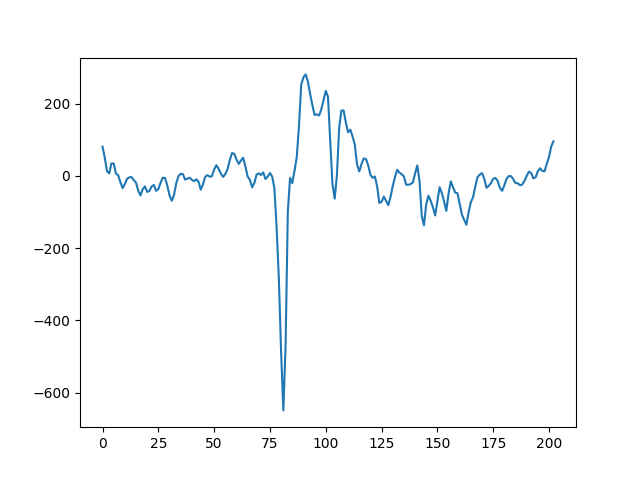

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(aligned_spikes[2034,:])



In [10]:
css._align_spikes(remove_align_overlaps=False)

# css.run(use_filtered=False)
# print(css.cs_indices.shape)

css._cluster_spike_by_feature(remove_overlaps=False)

css.cs_indices.shape

Using all spikes for alignment (no overlap removal)


(2708,)

In [ ]:
plt.figure()
plt.plot(css.voltage[])

In [51]:
print(css.spike_indices.shape)
print(np.unique(css.spike_indices).shape)

(88162,)
(38661,)


<IPython.core.display.Javascript object>


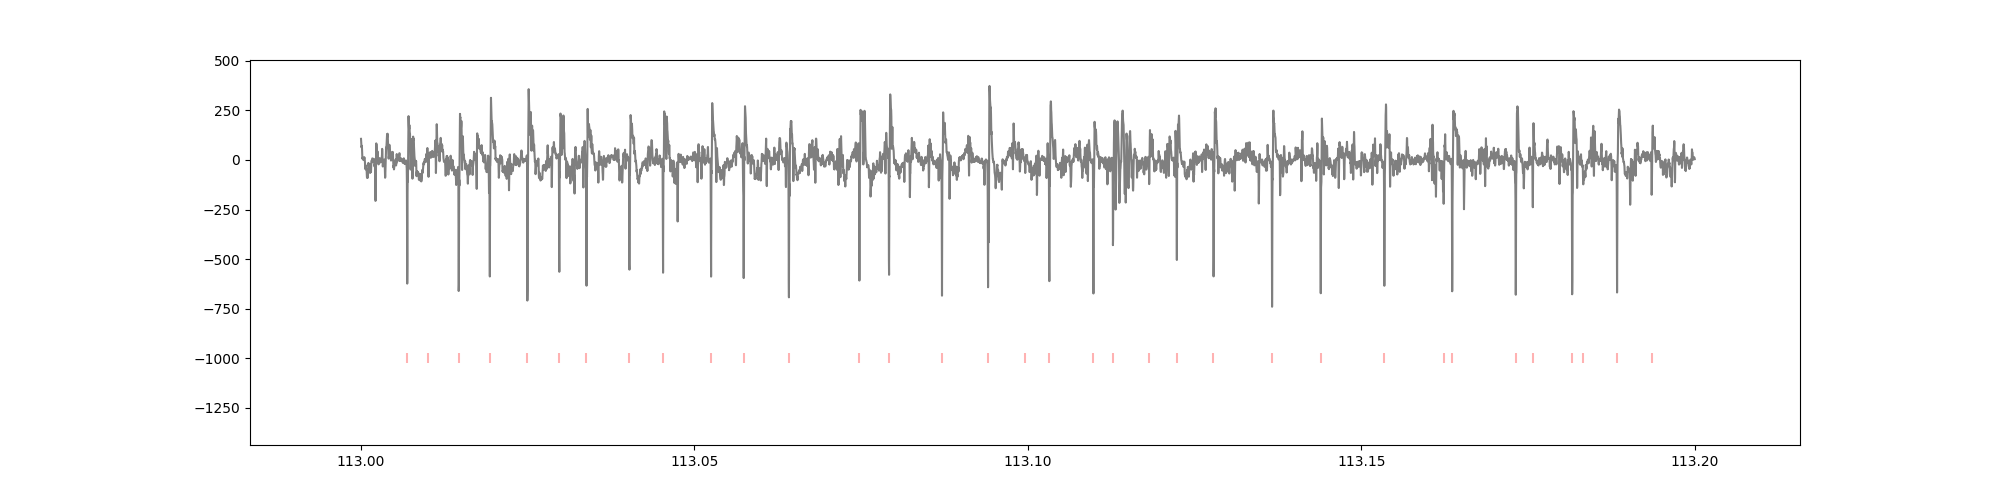

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
prange = [113,113.2] #s
idx_voltage = [int(pr*Fs) for pr in prange]
idx_lfp = [int(pr*Fs_lfp) for pr in prange]
plt.plot(np.arange(prange[0],prange[1],1/Fs), css.voltage[idx_voltage[0]: idx_voltage[1]+1], alpha=0.5, color='k')
plt.eventplot(css.spike_indices[np.where(np.logical_and(css.spike_indices < idx_voltage[1]+ 1 , css.spike_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=-1000, color='r', alpha = 0.3)

<IPython.core.display.Javascript object>


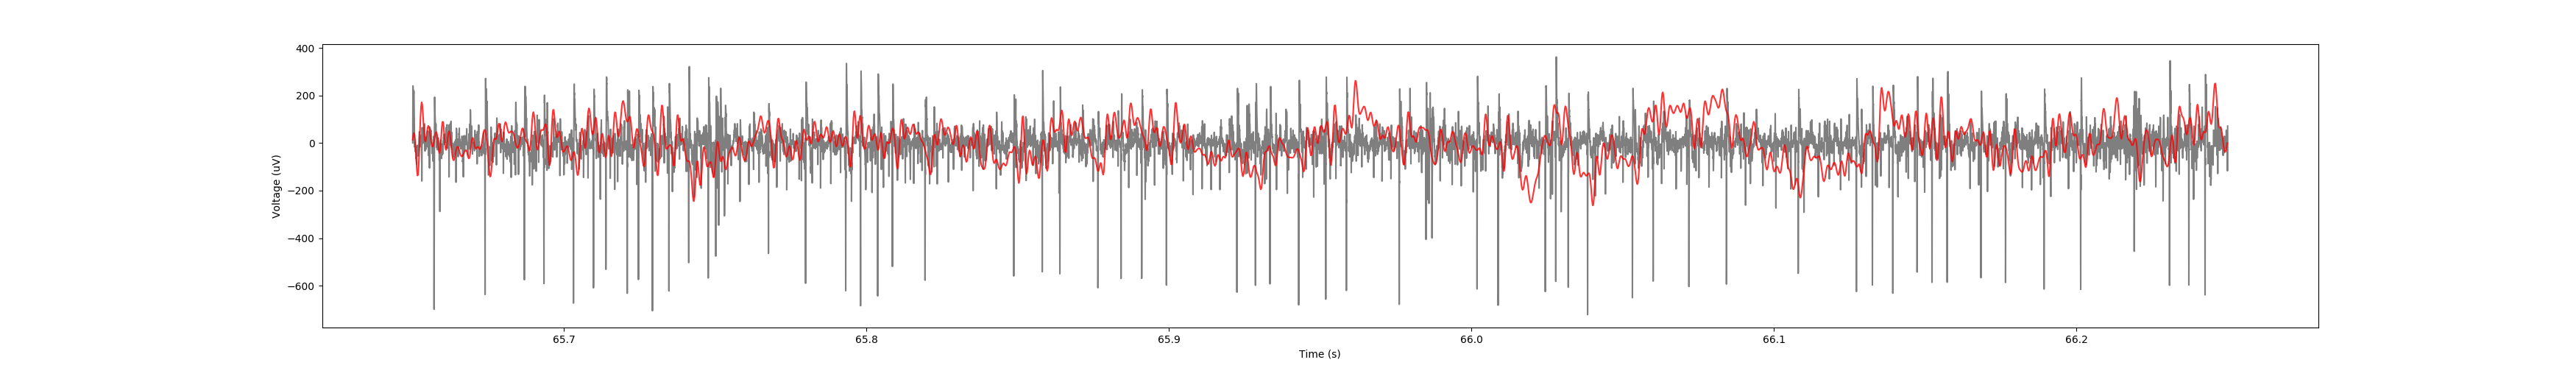

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(35,5))
prange = [65.65,66.25] #s
idx_voltage = [int(pr*Fs) for pr in prange]
idx_lfp = [int(pr*Fs_lfp) for pr in prange]
plt.plot(np.arange(prange[0],prange[1],1/Fs), voltage[idx_voltage[0]: idx_voltage[1]+1], alpha=0.5, color='k')
plt.plot(np.arange(prange[0],prange[1],1/Fs_lfp), lfp[idx_lfp[0]: idx_lfp[1]+1], alpha=0.8, color='r')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.savefig('../data/plots/For_cssorter_paper/mouse_trace_with_lfp.png')
plt.savefig('../data/plots/For_cssorter_paper/mouse_trace_with_lfp.svg')
plt.show()

Using minibatch spike detection, batch size = 50s
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative


Using all spikes for alignment (no overlap removal)


In [17]:
csiss = np.diff(css.cs_indices)
# cs_dups = cs_indices[np.where(csiss<0.010*Fs)]
cs_new = np.delete(css.cs_indices, np.where(csiss<0.010*Fs))

In [18]:
cs_new.shape

(3409,)

In [13]:
css.cs_indices=cs_new

In [45]:
num_clusters = 12
pre_time = 0.0005
post_time = 0.0022
clusters, cluster_labels = css.cluster_detected_cs(num_clusters=num_clusters, pre_time=pre_time, post_time=post_time, align_to='min')
ss_indices = css.get_ss_indices()
import random
pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
aligned_ss = np.array([css.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])
mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), css.cs_indices.size), ], axis=0)


<IPython.core.display.Javascript object>


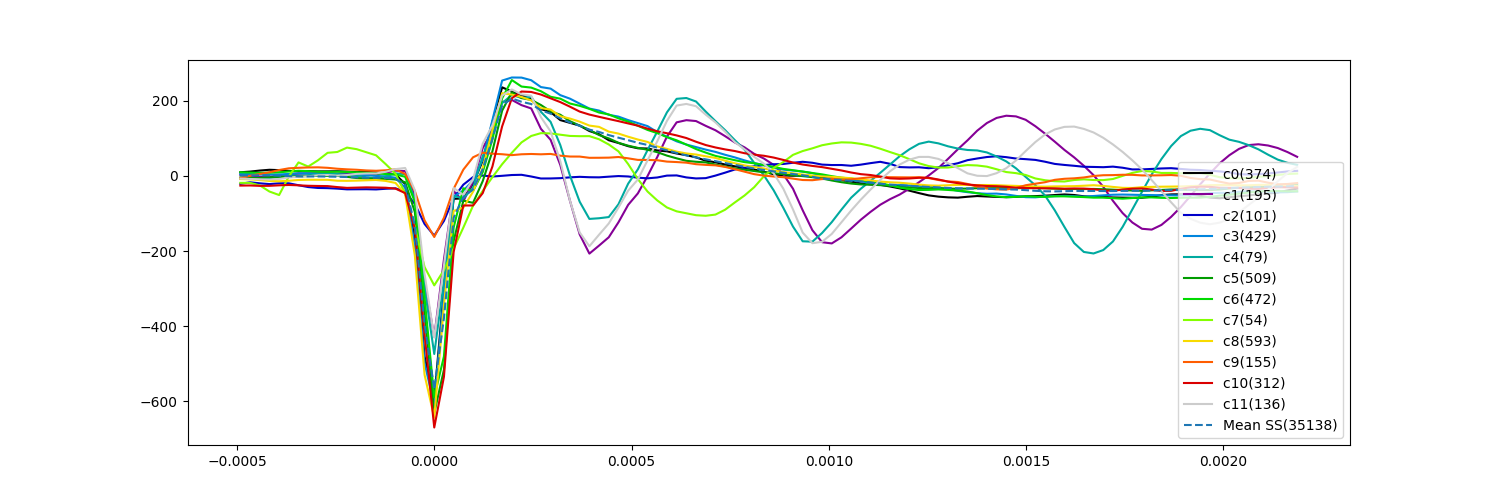

In [46]:
# plot cluster means
import matplotlib.pyplot as plt

colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
legend_labels = []
for cn in np.arange(num_clusters):
    legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

import gc
gc.collect()
plt.figure(figsize=(15,5))
clust_means = []
paxes = []
for cn in np.arange(num_clusters):
    clust_means.append(np.mean(clusters[cn], axis=0))
    ax = plt.plot(np.arange(-pre_index,post_index)*css.dt, clust_means[-1], color = colors[cn], label = legend_labels[cn])
    paxes.append(ax)
plt.plot(np.arange(-pre_index,post_index)*css.dt, mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
# plt.xticks(plt.xticks()[0], plt.xticks()[0]*css.dt)
plt.legend() 

In [47]:
import re
ans = input("Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: ")
ans_regex = re.compile(r'\d+(?:,\d+)?')
if ans_regex.match(ans):
    clusters_to_pick = [int(c) for c in ans.split(',')]

Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: 1,4,11


In [48]:
cs_indices_to_pick = []
for cti in clusters_to_pick:
    cs_indices_to_pick = np.union1d(cs_indices_to_pick, css.cs_indices[np.where(cluster_labels == cti)])
cs_indices = cs_indices_to_pick.astype(np.int64)
print('Number of detected CS: {}'.format(cs_indices.shape))

Number of detected CS: (410,)


In [82]:
css.signal_size*css.dt

235.232722944

In [182]:
cs_indices.shape

(377,)

<IPython.core.display.Javascript object>


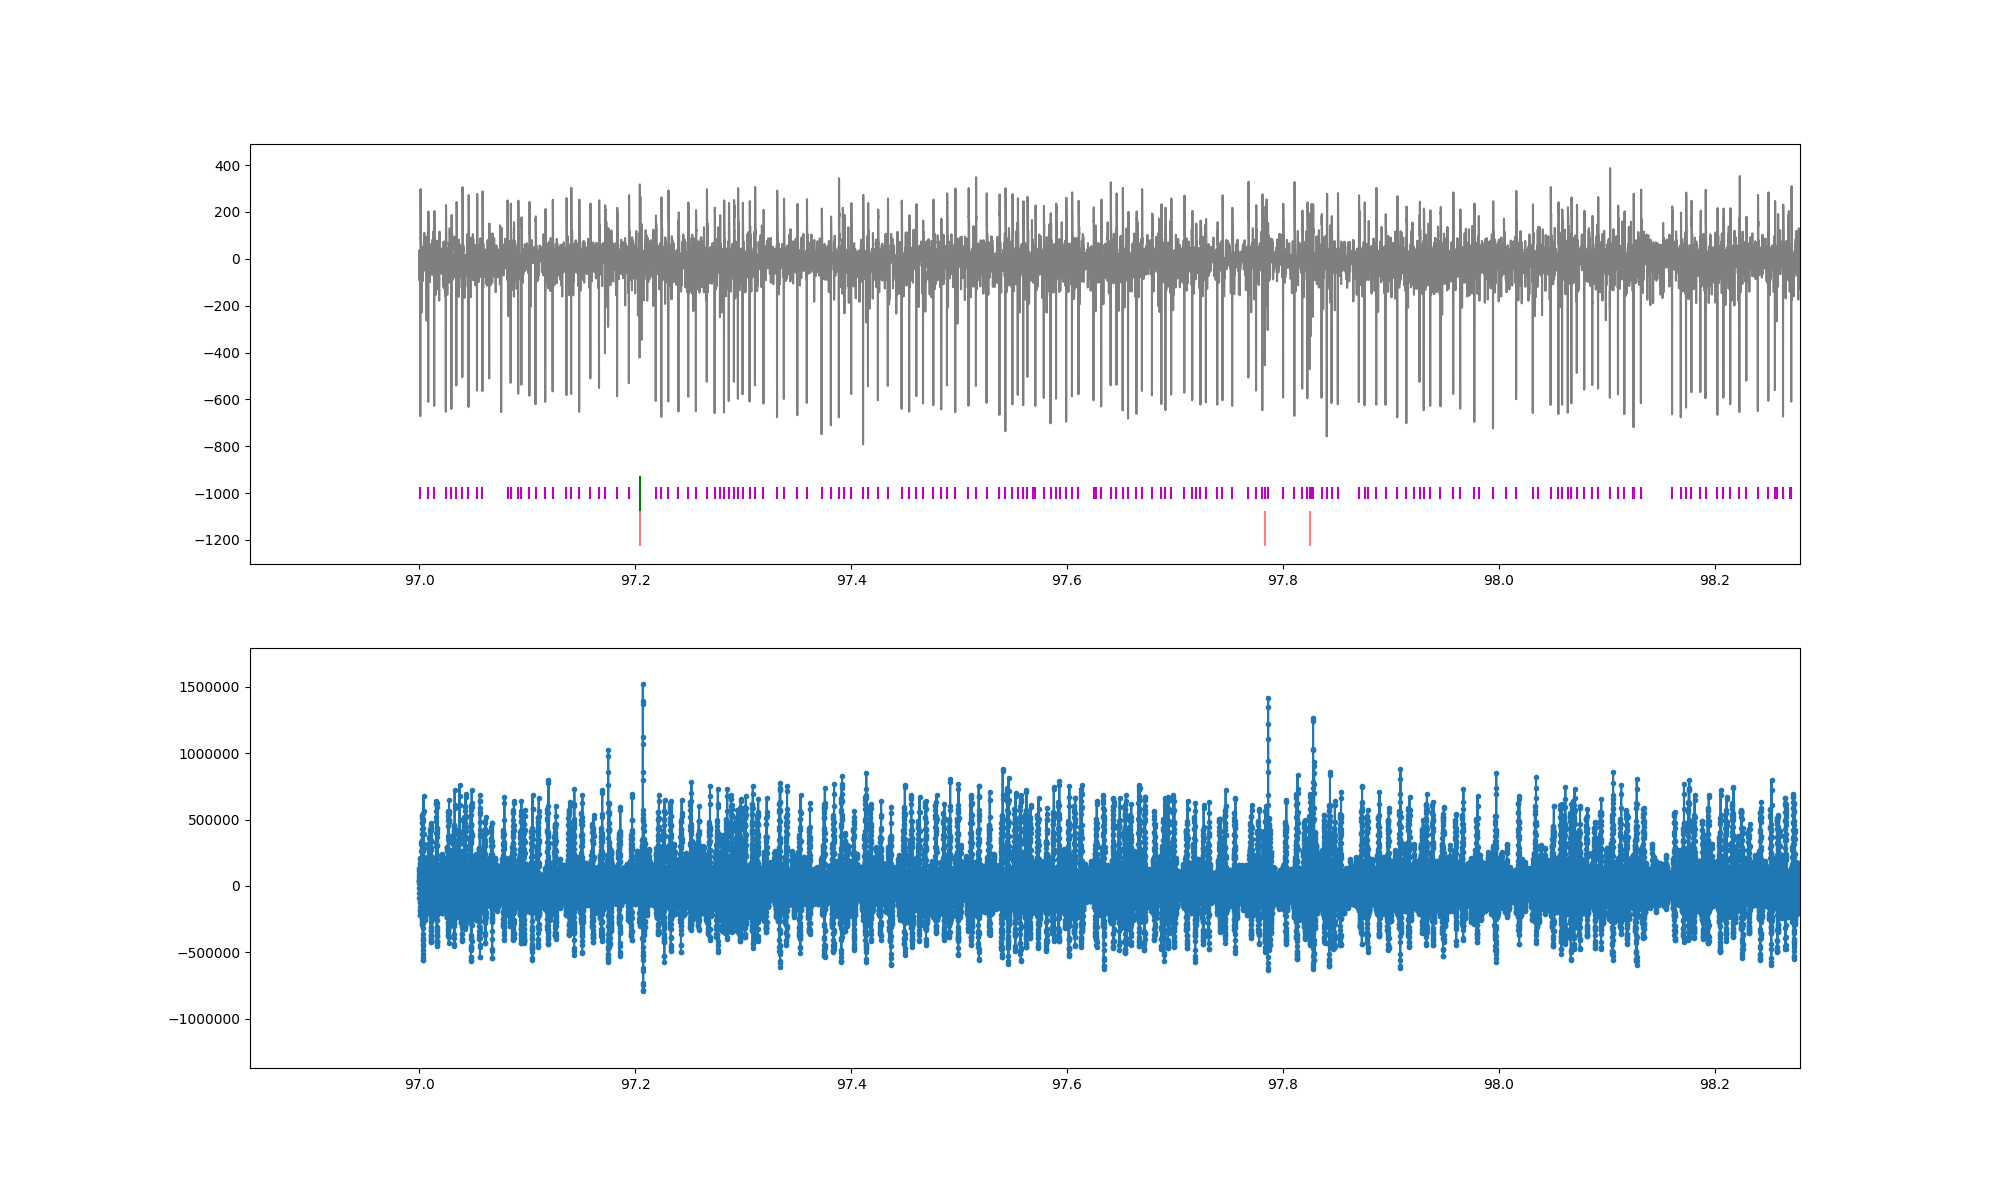

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,12))
ax1 = plt.subplot(211)
prange = [97,240.01] #s
idx_voltage = [int(pr*Fs) for pr in prange]
idx_lfp = [int(pr*Fs_lfp) for pr in prange]
plt.plot(np.arange(prange[0],prange[1],1/Fs), css.voltage[idx_voltage[0]: idx_voltage[1]+1], alpha=0.5, color='k')
plt.eventplot(css.spike_indices[np.where(np.logical_and(css.spike_indices < idx_voltage[1]+ 1 , css.spike_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=-1000, color='m')
# ss_indices = css.get_spike_indices()
# plt.eventplot(ss_indices[np.where(np.logical_and(ss_indices < idx_voltage[1]+ 1 , ss_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=-1050, color='b')

plt.eventplot(cs_indices[np.where(np.logical_and(cs_indices < idx_voltage[1]+ 1 , cs_indices >= idx_voltage[0]))]*css.dt, linelengths=150, lineoffsets=-1150, color='r', alpha = 0.5)
plt.eventplot(cs_new2[np.where(np.logical_and(cs_new2 < idx_voltage[1]+ 1 , cs_new2 >= idx_voltage[0]))]*css.dt, linelengths=150, lineoffsets=-1000, color='g')


plt.subplot(212, sharex=ax1)
plt.plot(np.arange(prange[0],prange[1],1/Fs), z[idx_voltage[0]: idx_voltage[1]+1], '.-')

In [48]:
cs_new2.shape

(260,)

In [52]:
pre_index = int(0.020*Fs)
post_index = int(0.020*Fs)
aligned_cs = []
aligned_cs_indices = []
for i in cs_indices:
    cs_idx = np.argmin(css.voltage[i - int(0.0025*Fs) : i + int(0.002*Fs)])+i
    aligned_cs_indices.append(cs_idx)
    aligned_cs.append(css.voltage[cs_idx - pre_index : cs_idx + post_index])

aligned_cs = np.array(aligned_cs)
aligned_cs_indices = np.array(aligned_cs_indices)


<IPython.core.display.Javascript object>


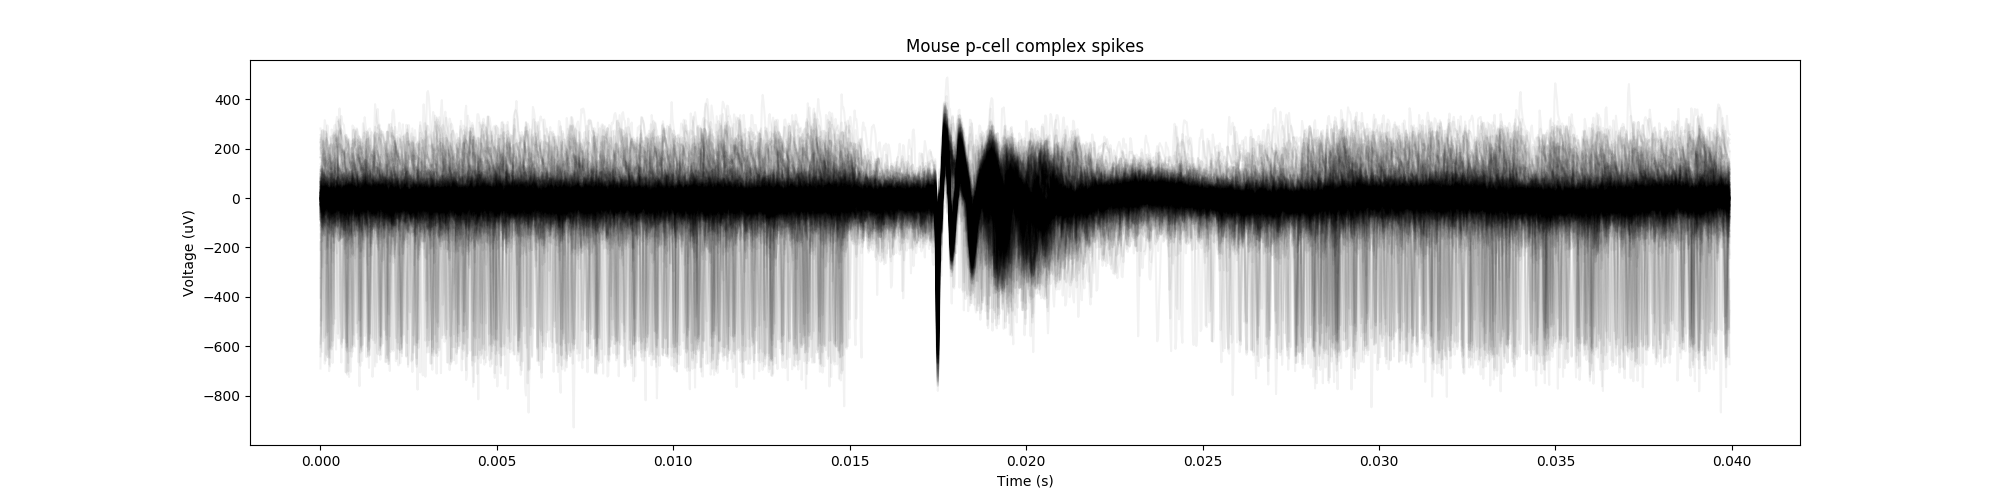

Text(0.5, 1.0, 'Mouse p-cell complex spikes')

In [53]:
plt.figure(figsize=(20,5))
# csi = cs_indices[7]
# print(csi*dt)
for acs in aligned_cs:
    plt.plot(np.arange(0,acs.size*dt, dt), acs, color='k', alpha=0.05)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('Mouse p-cell complex spikes')

In [27]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(8, covariance_type = 'full').fit(aligned_cs)
cluster_labels = gmm.predict(aligned_cs)


In [36]:
clusters = []
for cn in np.arange(gmm.n_components):
    clusters.append(aligned_cs[np.where(cluster_labels == cn)])


In [24]:
cs_new2 = cs_indices[np.where(cluster_labels == 0)]

In [49]:
cs_waveform = gmm.means_[0]

In [54]:
z = signal.correlate(css.voltage, cs_waveform, mode='same', method='fft')

In [37]:
clusters[4].shape

(81, 284)

<IPython.core.display.Javascript object>


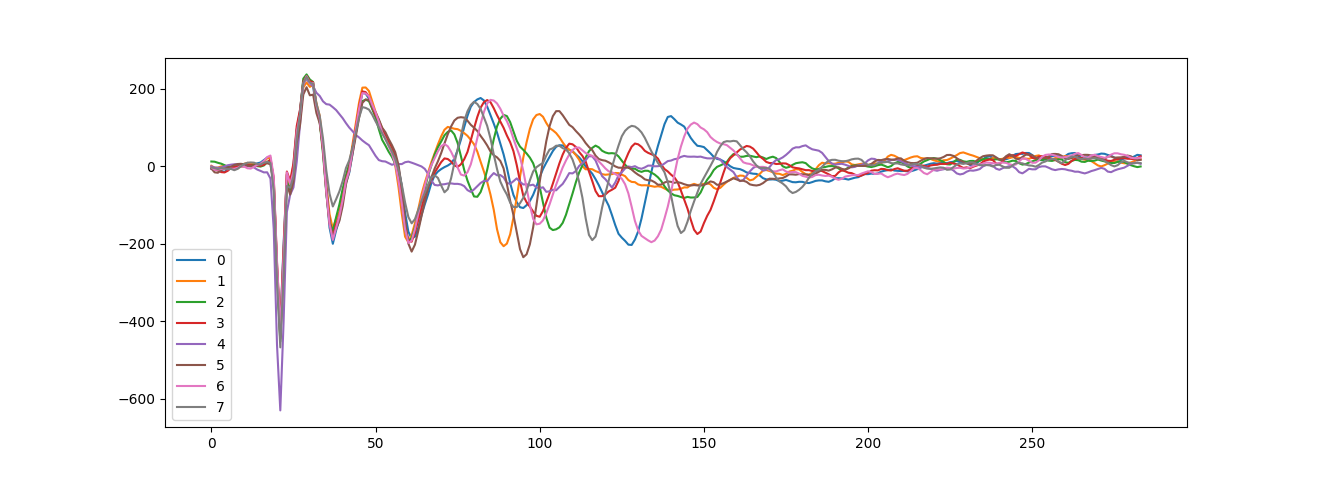

In [29]:
plt.figure()
plt.plot(gmm.means_.T)
plt.legend(np.arange(gmm.n_components))


In [89]:
css.aligned_spikes.shape


(87701, 195)

In [93]:
np.random.randint(0,css.aligned_spikes.shape[0], size=200)

array([67486, 52863, 17290, 27342, 36979, 36228, 24123, 65362, 87563,
       10807, 66980,  8818, 60149, 25660, 48476, 68266, 43503, 77001,
       73692, 11590, 30236, 59210, 15923, 40382, 52390, 37918, 25472,
        9045, 80158,  2511, 35721, 52617, 70553, 74189, 59732, 60185,
       75271, 28138, 16764, 57576, 11222, 57015, 19788,  2401, 51232,
        3305, 60763,   450, 55529, 15989,   269, 21020, 54944, 15262,
       51386, 79144, 50532, 48788, 53173, 36411, 55587, 36039, 70080,
       34429, 63099, 45447, 84264, 45761, 14337,  8464,  6593, 14488,
       38789, 68449,   151, 77800, 21613, 20831, 12265, 75595, 69945,
       64530,  1590, 32942, 23639, 15660, 83892, 66595, 77612, 54022,
       47231,  2069,   691,   163, 53097, 72932, 20046, 65391, 47464,
       19048, 85641, 86654, 44853, 11524, 53489, 43066, 25131, 36229,
       55790, 39920, 29839,  5517, 82463, 52401, 42099, 36194, 33581,
       55538, 11309, 39100, 39074,  9403, 13282,  4895, 80035, 80061,
       28167, 59383,

In [112]:
css.pre_window = -css.pre_window
css._align_spikes(use_filtered=False, remove_align_overlaps=False)

Using all spikes for alignment (no overlap removal)


<IPython.core.display.Javascript object>


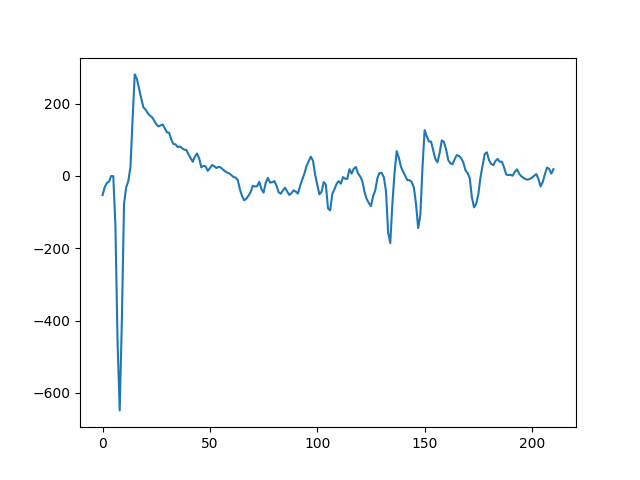

In [113]:
plt.figure()
plt.plot(css.aligned_spikes[1328,:])

<IPython.core.display.Javascript object>


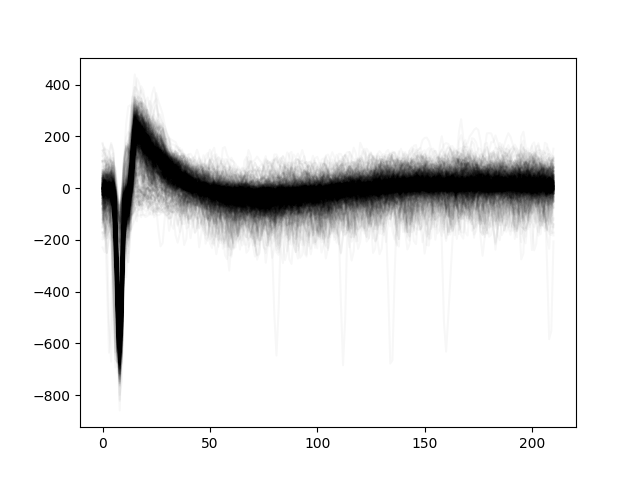

In [175]:
plt.figure()
plt.plot(css.aligned_spikes[np.random.randint(0,css.aligned_spikes.shape[0], size=700)].T, color = 'k', alpha = 0.03)

In [88]:
plt.savefig('../data/plots/For_cssorter_paper/mouse_detected_cs_overlaid2.png')
plt.savefig('../data/plots/For_cssorter_paper/mouse_detected_cs_overlaid2.svg')

<IPython.core.display.Javascript object>


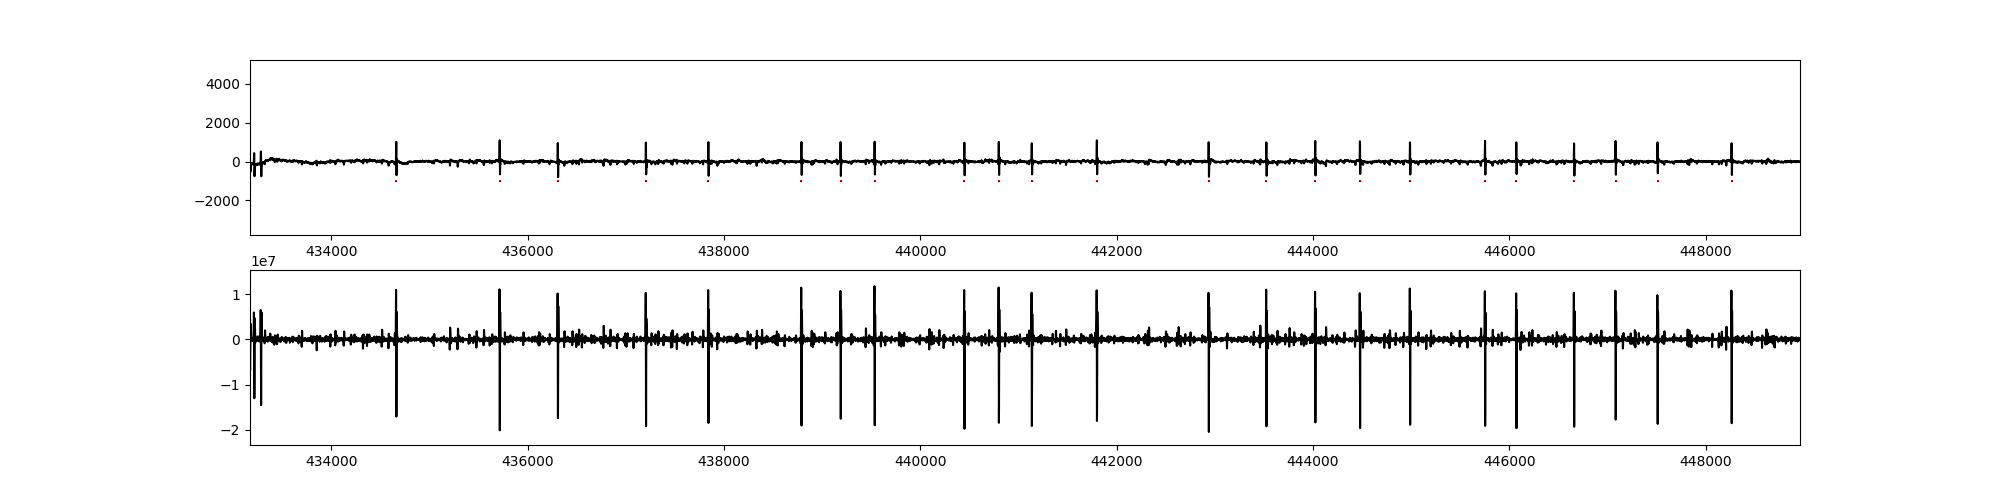

In [54]:
plt.figure(figsize=(20,5))
ax1 = plt.subplot(211)
plt.plot(css.voltage[0:int(100*Fs)], color = 'k')
plt.eventplot(css.spike_indices[np.where(css.spike_indices < 100*Fs+ 1)], linelengths=50, lineoffsets=-1000, color='r')
ss_indices = css.get_spike_indices()
plt.eventplot(ss_indices[np.where(ss_indices < 100*Fs+ 1)], linelengths=50, lineoffsets=-1050, color='b')
plt.eventplot(cs_indices[np.where(cs_indices < 100*Fs+ 1)], linelengths=150, lineoffsets=-1100, color='g')
plt.eventplot(cs_new[np.where(cs_new < 100*Fs+ 1)], linelengths=150, lineoffsets=-1250, color='m')

plt.subplot(212, sharex=ax1)
plt.plot(css.voltage_filtered[0:int(100*Fs)], color = 'k')

# plt.eventplot(css.cs_indices[np.where(css.cs_indices < 500*Fs+ 1)], linelengths=50, lineoffsets=-350, color='r')


In [4]:
arr = range(100)

In [13]:
import numpy as np

In [38]:
a = np.array([[i,[0,1,2]] for i in arr])[:,0]


In [40]:
a.shape

(100,)

In [36]:
np.array([r for r in a]).shape

(100, 3)

In [12]:
%matplotlib notebook

In [128]:
css.voltage[i - int(0.0009*Fs) : i + int(0.002*Fs)]

array([], dtype=float32)

In [146]:
pre_index = int(0.020*Fs)
post_index = int(0.020*Fs)
aligned_cs = []
for i in css.cs_indices[1:-2]:
    cs_idx = np.argmax(css.voltage[i - int(0.0019*Fs) : i + int(0.002*Fs)])+i
    aligned_cs.append(css.voltage[cs_idx - pre_index : cs_idx + post_index])
# aligned_cs = np.array([css.voltage[i - pre_index : i + post_index] for i in css.cs_indices[1:-2]])

In [147]:
aligned_cs = np.array(aligned_cs)

In [149]:
acs.shape

(1626,)

<IPython.core.display.Javascript object>


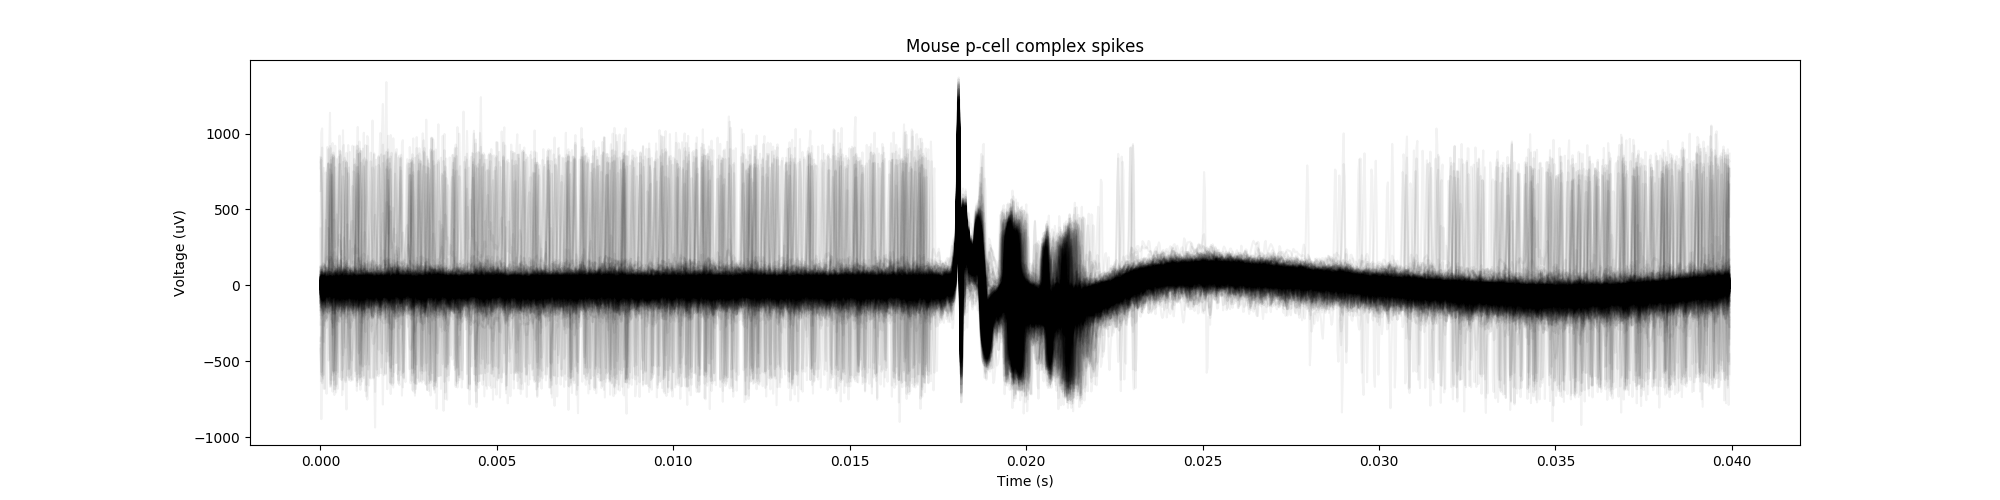

Text(0.5, 1.0, 'Mouse p-cell complex spikes')

In [153]:
plt.figure(figsize=(20,5))
# csi = cs_indices[7]
# print(csi*dt)
for acs in aligned_cs:
    plt.plot(np.arange(0,acs.size*dt, dt), acs, color='k', alpha=0.05)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('Mouse p-cell complex spikes')

In [154]:
plt.savefig('../data/plots/For_cssorter_paper/mouse_detected_cs_overlaid.png')
plt.savefig('../data/plots/For_cssorter_paper/mouse_detected_cs_overlaid.svg')

<IPython.core.display.Javascript object>


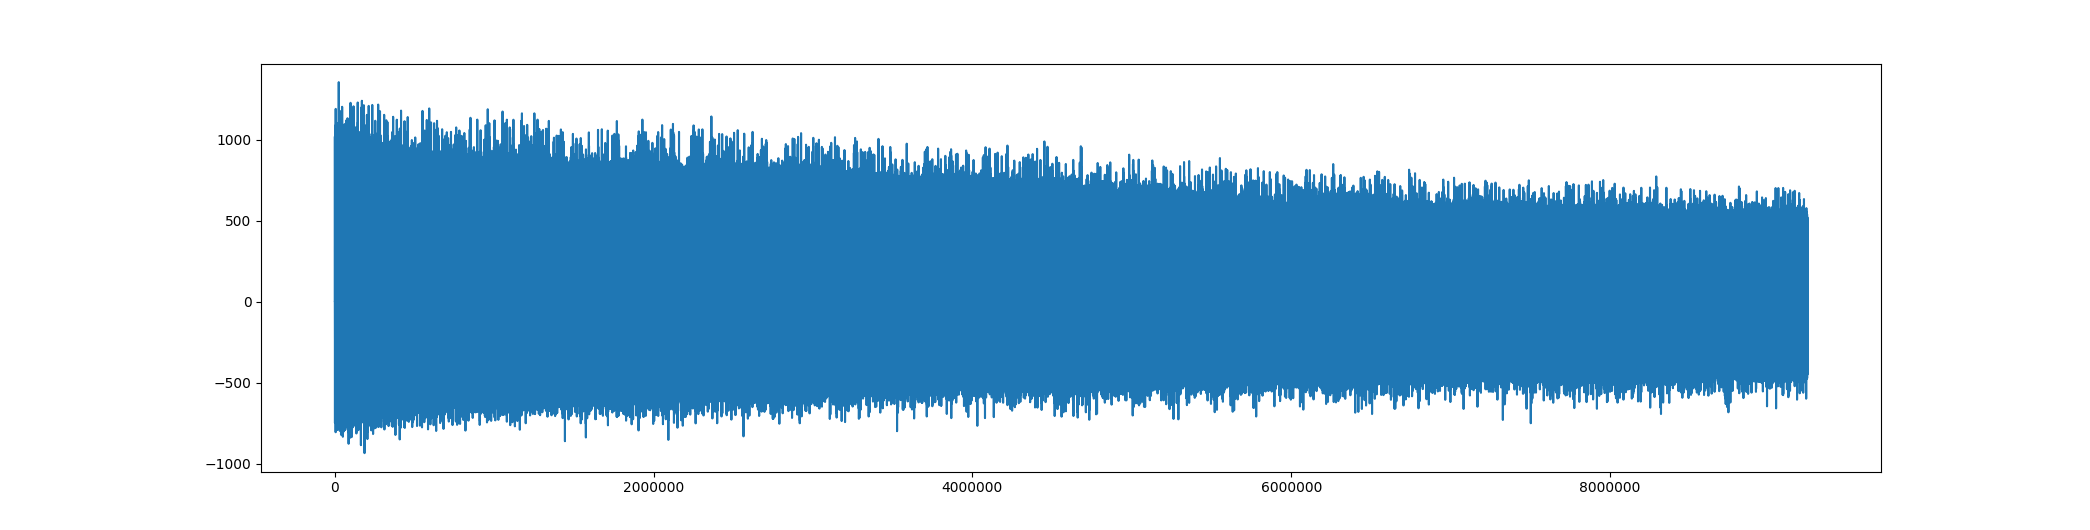

In [70]:
plt.figure()
plt.plot(css.voltage[::5])